# Gather and format EU windstorm observations

In [1]:
import sys
sys.path.append('../../..')  # Package root directory

import logging
import climada
import warnings
import pandas as pd
import numpy as np
from pathlib import Path
import copy
from climada.util import log_level
from climada.util.api_client import Client
from climada.util.constants import SYSTEM_DIR


logging.getLogger("climada").setLevel("WARNING")
warnings.filterwarnings("ignore", category=DeprecationWarning)

/usr/local/Caskroom/miniforge/base/envs/nccs_dev_jupyter/lib/python3.11/site-packages/dask/dataframe/_pyarrow_compat.py:17: FutureWarning: Minimal version of pyarrow will soon be increased to 14.0.1. You are using 12.0.1. Please consider upgrading.
  warnings.warn(


We filter to region and hazard:
- we include storm subtypes 'Extra-tropical storm', 'Storm (General)', 'Tropical cyclone' (since some storms are transitioned tropical storms)
- we exclude storm subtypes 'Blizzard/Winter storm' (fwe events, mostly non-wind losses or in Russia), 'Derecho', 'Hail', 'Tornado' and 'Lightning/Thunder Storms' (convective systems: different peril)
- we exclude Russia: not all events are in the European part of it (e.g. some typhoons) and it didn't seem worth doing a careful filter 

In [5]:
countries_to_filter_to = []  # Leave empty to use all
output_dir = Path('/Users/chrisfairless/Projects/CelsiusPro/nccs-supply-chain/resources/observations/data')
emdat = pd.read_csv(Path(output_dir, 'raw', 'public_emdat_custom_request_2024-03-25_2f081933-bed3-41c7-9825-91371555fd41.csv'))
disaster_subtypes = ['Extra-tropical storm', 'Storm (General)', 'Tropical cyclone']
subregions = ['Northern Europe', 'Southern Europe', 'Eastern Europe', 'Western Europe']
emdat_subset = emdat[
    (emdat['Disaster Subtype'].isin(disaster_subtypes)) &
    (emdat['Subregion'].isin(subregions)) &
    (emdat["Total Damage ('000 US$)"] > 0) &
    (emdat["ISO"] != 'RUS')
]

# fix missing damage obs
emdat_subset[emdat_subset['Start Year'] == 2023]["Total Damage, Adjusted ('000 US$)"] = emdat_subset[emdat_subset['Start Year'] == 2023]["Total Damage ('000 US$)"]

if len(countries_to_filter_to) > 0:
    emdat_subset = emdat_subset.iloc[[i for i, c in enumerate(emdat_subset['Country']) if c in countries_to_filter_to]]
else:
    countries_to_filter_to = np.unique(emdat_subset[["Country"]])

emdat_subset

,DisNo.,Historic,Classification Key,Disaster Group,Disaster Subgroup,Disaster Type,Disaster Subtype,External IDs,Event Name,ISO,...,Reconstruction Costs ('000 US$),"Reconstruction Costs, Adjusted ('000 US$)",Insured Damage ('000 US$),"Insured Damage, Adjusted ('000 US$)",Total Damage ('000 US$),"Total Damage, Adjusted ('000 US$)",CPI,Admin Units,Entry Date,Last Update
176,1941-0036-PRT,Yes,nat-met-sto-sto,Natural,Meteorological,Storm,Storm (General),NaN,NaN,PRT,...,NaN,NaN,NaN,NaN,40000.0,796463.0,5.022207,NaN,2021-08-24,2023-09-25
763,1968-0022-GBR,Yes,nat-met-sto-sto,Natural,Meteorological,Storm,Storm (General),NaN,NaN,GBR,...,NaN,NaN,NaN,NaN,2500.0,21034.0,11.885447,NaN,2003-07-01,2023-09-25
892,1970-0047-ITA,Yes,nat-met-sto-tro,Natural,Meteorological,Storm,Tropical cyclone,NaN,NaN,ITA,...,NaN,NaN,NaN,NaN,3200.0,24121.0,13.266480,NaN,2003-07-01,2023-09-25
943,1971-0046-ESP,Yes,nat-met-sto-sto,Natural,Meteorological,Storm,Storm (General),NaN,NaN,ESP,...,NaN,NaN,NaN,NaN,55000.0,397514.0,13.835984,NaN,2003-07-01,2023-09-25
999,1972-0061-DFR,Yes,nat-met-sto-sto,Natural,Meteorological,Storm,Storm (General),NaN,NaN,DFR,...,NaN,NaN,NaN,NaN,420000.0,2939379.0,14.288734,NaN,2003-07-01,2023-09-25
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11052,2021-0320-UKR,No,nat-met-sto-ext,Natural,Meteorological,Storm,Extra-tropical storm,NaN,NaN,UKR,...,NaN,NaN,NaN,NaN,170000.0,183605.0,92.590193,"[{""adm1_code"":3158,""adm1_name"":""Krym""}]",2021-06-22,2023-09-25
11344,2022-0112-DEU,No,nat-met-sto-ext,Natural,Meteorological,Storm,Extra-tropical storm,NaN,Storm 'Eunice' (Zeynep),DEU,...,NaN,NaN,NaN,NaN,1023156.0,1023156.0,100.000000,NaN,2022-02-24,2023-09-25
11346,2022-0112-GBR,No,nat-met-sto-ext,Natural,Meteorological,Storm,Extra-tropical storm,NaN,Storm 'Eunice' (Zeynep),GBR,...,NaN,NaN,NaN,NaN,491342.0,491342.0,100.000000,NaN,2022-02-24,2023-09-25
11348,2022-0112-NLD,No,nat-met-sto-ext,Natural,Meteorological,Storm,Extra-tropical storm,NaN,Storm 'Eunice' (Zeynep),NLD,...,NaN,NaN,NaN,NaN,568420.0,568420.0,100.000000,NaN,2022-02-24,2023-09-25


Summarise event losses by subtype: 

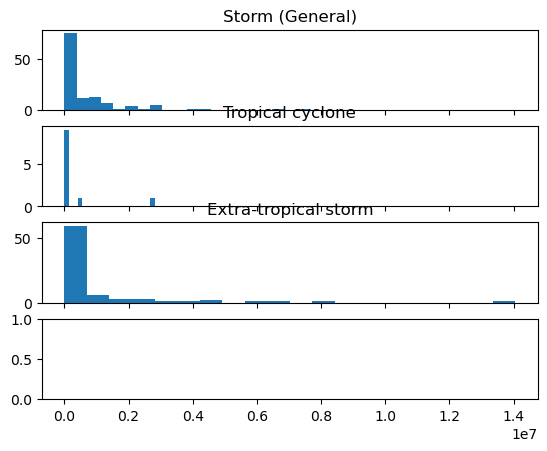

In [6]:
%matplotlib inline
import matplotlib.pyplot as plt

flood_types = emdat_subset['Disaster Subtype'].unique()

emdat_subset.groupby('Disaster Subtype').agg('count')['DisNo.']

fig, axs = plt.subplots(4, 1, sharex=True)
for ax, ftype in zip(axs.reshape(-1), flood_types):
    losses = emdat_subset[emdat_subset['Disaster Subtype'] == ftype]["Total Damage, Adjusted ('000 US$)"]
    losses = losses[losses > 0]
    ax.hist(losses, bins=20)
    ax.set_title(ftype)


Text(0.5, 1.0, 'Event Counts by Year')

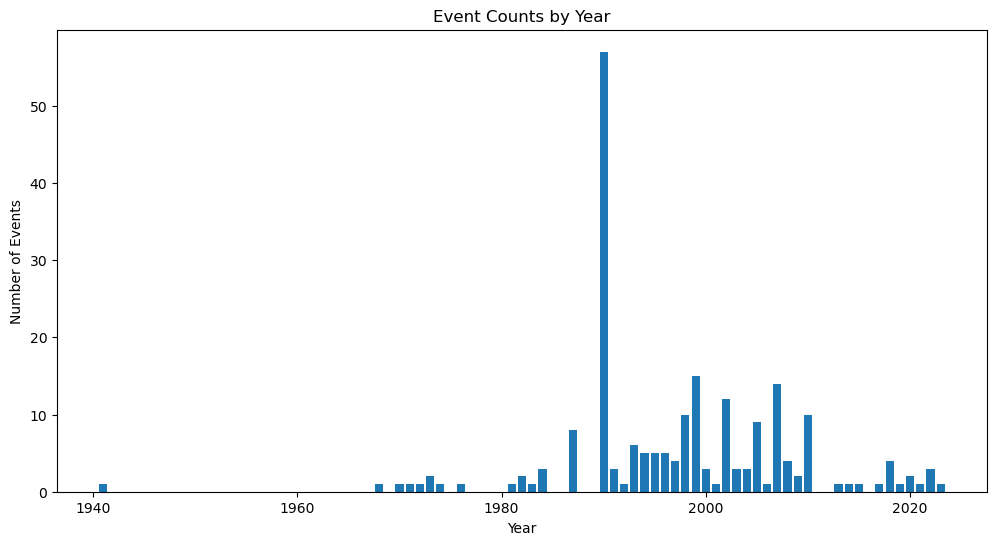

In [7]:
# Visualise event frequency
counts = emdat_subset[['Start Year', 'DisNo.']].drop_duplicates().groupby(['Start Year']).size().reset_index(name='count')

all_years = pd.DataFrame({'Start Year': range(counts['Start Year'].min(), counts['Start Year'].max() + 1)})
counts_filled = all_years.merge(counts, on='Start Year', how='left').fillna(0)
plt.figure(figsize=(12, 6))
plt.bar(counts_filled['Start Year'], counts_filled['count'])
plt.xlabel('Year')
plt.ylabel('Number of Events')
plt.title('Event Counts by Year')

EM-DAT warns that data before the year 2000 is incomplete. Here it looks like 1990 was the start of 'good' data coverage. (The large number of events here comes from multiple events affecting multiple countries)

Let's set a cutoff of 1990. If we decide we need more events we can reconsider this decision, since it's likely that missing events are smaller events, which aren't so important for the calibration.

In [8]:
year_range = (1990, 2023)
emdat_subset = emdat_subset[
    (emdat_subset['Start Year'] >= year_range[0]) &
    (emdat_subset['Start Year'] <= year_range[1])
]

n_years = year_range[1] - year_range[0] + 1

In [10]:
from copy import deepcopy

rps = deepcopy(emdat_subset)[['Start Year', 'DisNo.', 'ISO', 'Disaster Subtype', "Total Damage, Adjusted ('000 US$)"]]
rps = rps.rename(columns={
    'Start Year': 'year',
    'DisNo.': 'emdat_eventcountry_id',
    'ISO': 'country',
    'Disaster Subtype': 'type',
    "Total Damage, Adjusted ('000 US$)": 'emdat_impact_scaled'
    })
rps['event_id'] = ['-'.join(s.split('-')[:-1]) for s in rps['emdat_eventcountry_id']]
rps = rps.sort_values(['country', 'year', 'emdat_impact_scaled'], ascending=[True, True, False])
print(rps)
rps.to_csv(Path(output_dir, 'ws_full.csv'), index=False)

       year emdat_eventcountry_id country                  type  \
2866   1990         1990-0722-AUT     AUT       Storm (General)   
2879   1990         1990-0723-AUT     AUT       Storm (General)   
2858   1990         1990-0721-AUT     AUT       Storm (General)   
3434   1994         1994-0015-AUT     AUT       Storm (General)   
4769   2000         2000-0311-AUT     AUT       Storm (General)   
...     ...                   ...     ...                   ...   
3193   1992         1992-0477-UKR     UKR      Tropical cyclone   
4065   1997         1997-0200-UKR     UKR      Tropical cyclone   
4934   2000         2000-0784-UKR     UKR       Storm (General)   
6872   2007         2007-0019-UKR     UKR  Extra-tropical storm   
11052  2021         2021-0320-UKR     UKR  Extra-tropical storm   

       emdat_impact_scaled   event_id  
2866              268782.0  1990-0722  
2879              268782.0  1990-0723  
2858               22398.0  1990-0721  
3434                3949.0  1994-00

In [11]:
def calc_rps(rps):
    rps = rps.rename(columns={'emdat_impact_scaled': 'impact'}).reset_index()
    n_years = np.max(rps['year']) - np.min(rps['year']) + 1
    rp_agg = rps[['country', 'year', 'impact']].groupby(['country', 'year']).agg('sum')
    rp_agg = rp_agg.sort_values(['country', 'impact'], ascending=[True, False])
    rp_agg['rank'] = rp_agg.groupby(['country']).cumcount() + 1
    rp_agg['rp'] = n_years / rp_agg['rank']
    rp_agg = rp_agg.reset_index()[['country', 'year', 'rp', 'impact']]
    return rp_agg

rp_agg = calc_rps(rps)
print(rp_agg)
rp_agg.to_csv(Path(output_dir, 'ws.csv'), index=False)

    country  year         rp    impact
0       AUT  2008  34.000000  679636.0
1       AUT  2007  17.000000  564583.0
2       AUT  1990  11.333333  559962.0
3       AUT  2000   8.500000   33990.0
4       AUT  2002   6.800000    8135.0
..      ...   ...        ...       ...
131     UKR  2000  34.000000  203941.0
132     UKR  2021  17.000000  183605.0
133     UKR  2007  11.333333  141146.0
134     UKR  1997   8.500000   61989.0
135     UKR  1992   6.800000    3337.0

[136 rows x 4 columns]
